# IMPORT

In [646]:
import json
import math
import numpy as np

import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

import matplotlib.pyplot as plt
import os

import string
from gensim.models import Word2Vec

----------------------------------------------------------------------------------------

# Création des data frame de base pour le dashboard et test

## Word2Vec

**Lecture fichier**

In [647]:
# name of the lightest file
file_name = "./jsonBases/topaz-data732--mali--www.egaliteetreconciliation.fr--20190101--20211231.json"

# open and load file
f = open(file_name, 'r', encoding='utf-8')
data = json.loads(f.read())
f.close()

**Ponctuations**

In [648]:
ponctuations = list(string.punctuation)
ponctuations.append('’')

**Recréation des articles avec seulement les mots importants et dans leur forme simple**

**Je vais faire des tests sur les kws**

In [649]:
docFinal = []
key='kws'
tabWord = []

for annee in data["data-all"]:
    for mois in data["data-all"][annee]:
        for article in data["data-all"][annee][mois]:
            dat = data["data-all"][annee][mois][article][0]['content'].split()
            dat = [doc.lower() for doc in dat]
            nDat = []
            for mot in dat:
                nMot = mot
                for l in mot:
                    if l in ponctuations:
                        if l == mot[0] or l == mot[len(mot) - 1]:
                            nMot = nMot.replace(l, "")
                        else:
                            indice = mot.index(l)
                            nMot = mot.replace(l, "")
                            nMot = mot[:indice - 1] + mot[indice + 1:]

                if nMot in data["data-all"][annee][mois][article][0][key]:
                    nDat.append(nMot)
                    if nMot not in tabWord :
                        tabWord.append(nMot)
            docFinal.append(nDat)

documents = [" ".join(doc) for doc in docFinal]
print(documents[0])
print(tabWord)

burkina faso violence djihadiste mardi attaque arbinda nord pays histoire pays deuil national président burkinabé roch kaboré personne compte twitter attaque barbare chef état burkinabé manque poigne face roch kaboré mardi matin détachement militaire arbinda province soum attaque rare intensité armée burkinabée fuite gouvernement soirée mardi décembre dizaine attaque hallalé pays pauvre afrique ouest niger mali début novembre société attaque convoi burkina nord pays décompte afp bilan février dernier peur soum opération sahel preuve situation expert militaire tiers burkina faso nord sud gars moto expert militaire article entier
['burkina', 'faso', 'violence', 'djihadiste', 'mardi', 'attaque', 'arbinda', 'nord', 'pays', 'histoire', 'deuil', 'national', 'président', 'burkinabé', 'roch', 'kaboré', 'personne', 'compte', 'twitter', 'barbare', 'chef', 'état', 'manque', 'poigne', 'face', 'matin', 'détachement', 'militaire', 'province', 'soum', 'rare', 'intensité', 'armée', 'burkinabée', 'fuit

**Création du modèle word2vec avec 2 dimensions**

In [650]:
modele = Word2Vec(docFinal, vector_size=2, window=5)
print(modele)

Word2Vec<vocab=991, vector_size=2, alpha=0.025>


**Vectorisation des mots**

In [651]:
words = modele.wv

print(words.vectors.shape)

(991, 2)


**Similarité entre 2 mots**

In [652]:
mot1 = "an"
mot2 = "mali"
print(words.similarity(mot1, mot2))

0.99999046


**Mots les plus proches d'un autre**

In [653]:
mot = "macron"
print(words.most_similar(mot))

[('cas', 1.0000001192092896), ('argent', 0.9999998807907104), ('jeune', 0.9999998807907104), ('emmanuel', 0.9999995231628418), ('problème', 0.9999994039535522), ('nouveau', 0.9999991059303284), ('crise', 0.999998927116394), ('cœur', 0.9999988079071045), ('traoré', 0.9999985694885254), ('occidental', 0.9999983310699463)]


**Mots les plus proches de la conjonction de "mot1" et "mot2" avec "nbMots" mots**

In [654]:
mot1 = "an"
mot2 = "mali"
nbMots = 4
print(words.most_similar(positive=[mot1, mot2], topn=nbMots))

[('février', 1.0), ('djihadisme', 1.0), ('vue', 0.9999999403953552), ('russe', 0.9999998211860657)]


**Mots les plus proches de "mot1" et loin de "mot2" avec "nbMots" mots**

In [655]:
mot1 = "an"
mot2 = "mali"
nbMots = 4
print(words.most_similar(positive=[mot1], negative=[mot2], topn=nbMots))

[('instant', 0.9663915634155273), ('neuf', 0.9333603978157043), ('parlementaire', 0.9131886959075928), ('recul', 0.899468719959259)]


**Récupérer un ensemble de donnée dans un dataFrame**

In [656]:
df = pd.DataFrame(words.vectors, columns=['V1', 'V2'], index=words.key_to_index.keys())
print(df)

                      V1        V2
france          3.643118  2.342859
mali            3.262413  2.310121
pays            3.376958  2.034911
français        3.226211  2.288170
président       2.942801  1.832841
...                  ...       ...
criminel        0.592325  0.022000
crif            0.206352  0.332529
attente         0.619913  0.486749
reconnaissance  0.234559  0.024308
rebelle        -0.017846  0.135989

[991 rows x 2 columns]


**Liste de mots importants que l'on veut voir sur une graphique pour voir leur similarité**

In [657]:
mots = ['mali', 'disparition', 'rare', 'grève', 'droit', 'femme', 'homme']
dfMots = df.loc[mots, :]
print(dfMots)

                   V1        V2
mali         3.262413  2.310121
disparition  0.472924  0.354594
rare         0.835280  0.038922
grève        0.823470  0.728922
droit        2.144849  1.243096
femme        1.563442  0.542740
homme        2.598418  1.255217


**Affichage de ces mots sur un graphique**

C:\Users\Mathieu\AppData\Local\Temp\ipykernel_12296\680670198.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



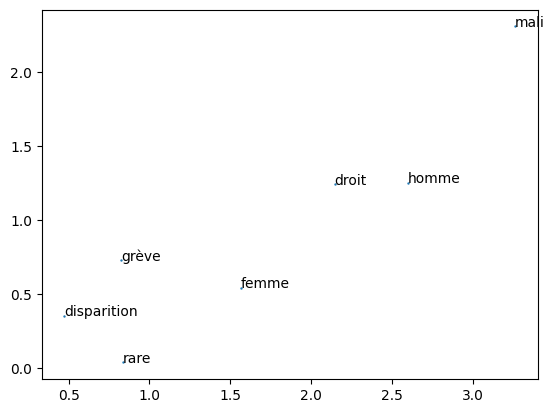

In [658]:
plt.scatter(dfMots.V1, dfMots.V2, s=0.5)
for i in range(dfMots.shape[0]):
    plt.annotate(dfMots.index[i], (dfMots.V1[i], dfMots.V2[i]))
plt.show()

--------------------------------------------------------------------------------------

### On va maintenant travailler sur les personnes

**On récupère tous les pays présents dans le corpus avec leurs différentes occurrences**

In [659]:
nb=0
dicoPer ={}
for annee in data["data-all"]:
    for mois in data["data-all"][annee]:
        for article in data["data-all"][annee][mois]:
            dicoPer[nb] = data["data-all"][annee][mois][article][0]['per']
            nb += 1
print(dicoPer)

{0: {'Roch Kaboré': 2}, 1: {}, 2: {'Alassane Ouattara': 3, 'Emmanuel Macron': 2}, 3: {'Linda Kebbab': 6}, 4: {'Michael Shurkin': 2, 'Barkhane': 2}, 5: {}, 6: {'Barkhane': 2}, 7: {}, 8: {'Lelièvre': 3, 'Alain Barrière': 3, 'Nick Conrad': 2, 'Pierre Soulages': 2, 'Claudine': 3}, 9: {'Macron': 3}, 10: {'Macron': 2, 'Barkhane': 2}, 11: {'Nicolas Sarkozy': 2, 'Sarkozy': 4, 'Alain Soral': 3, 'François Hollande': 2, 'Vladimir Poutine': 2, 'Xi Jinping': 2, 'Valls': 3, 'Manuel Valls': 2, 'Donald Trump': 4, 'Trump': 4, 'Erdoğan': 2, 'Président': 2, 'Macron': 2}, 12: {}, 13: {'Djerma': 2, 'Othman': 2, 'dan Fodio': 2, 'Seku Ahmadou': 2, 'El Hadj Omar': 2}, 14: {'Charlie': 3, 'Cabu': 2, 'Pelloux': 3, 'Marianne': 2, 'Charb': 2}, 15: {'Barkhane': 2}, 16: {}, 17: {'Emmanuel Macron': 4, 'Guillaume Bigot': 5}, 18: {'Abou Bakr al-Baghdadi': 2, 'Kadhafi': 2, 'Washington': 2}, 19: {'El Hadj Omar': 5, 'Édouard Philippe': 2, 'Seku Ahmadou': 2}, 20: {}, 21: {'Barkhane': 2, 'IBK': 2}, 22: {'Lassana Bathily': 7

**Normalisation des noms**

In [660]:
from unidecode import unidecode
# personnes = list(set(list(sum(dicoPer,[]))))
# print(personnes)

# Nouveau dictionnaire avec les noms modifiés
new_dicoPer = {}

for key, value in dicoPer.items():
    if value:  # Vérifie si le sous-dictionnaire n'est pas vide
        new_value = {}
        for name, count in value.items():
            # Enlève les accents, convertit en minuscules et conserve le dernier nom
            last_name = unidecode(name.split()[-1]).lower()
            new_value[last_name] = count
        new_dicoPer[key] = new_value

print(new_dicoPer)

{0: {'kabore': 2}, 2: {'ouattara': 3, 'macron': 2}, 3: {'kebbab': 6}, 4: {'shurkin': 2, 'barkhane': 2}, 6: {'barkhane': 2}, 8: {'lelievre': 3, 'barriere': 3, 'conrad': 2, 'soulages': 2, 'claudine': 3}, 9: {'macron': 3}, 10: {'macron': 2, 'barkhane': 2}, 11: {'sarkozy': 4, 'soral': 3, 'hollande': 2, 'poutine': 2, 'jinping': 2, 'valls': 2, 'trump': 4, 'erdogan': 2, 'president': 2, 'macron': 2}, 13: {'djerma': 2, 'othman': 2, 'fodio': 2, 'ahmadou': 2, 'omar': 2}, 14: {'charlie': 3, 'cabu': 2, 'pelloux': 3, 'marianne': 2, 'charb': 2}, 15: {'barkhane': 2}, 17: {'macron': 4, 'bigot': 5}, 18: {'al-baghdadi': 2, 'kadhafi': 2, 'washington': 2}, 19: {'omar': 5, 'philippe': 2, 'ahmadou': 2}, 21: {'barkhane': 2, 'ibk': 2}, 22: {'bathily': 7, 'coulibaly': 5, 'republique': 3, 'hollande': 3, 'valls': 2, 'lassana': 2}, 23: {'kacimi': 2}, 24: {'foucher': 4, 'gueant': 3, 'capital': 2, 'couriol': 4, 'mitterrand': 3, 'schaffhauser': 2, 'dumas': 2}, 27: {'al-qaeda': 2}, 29: {'bouhafs': 2}, 30: {'michel': 2

**Récupération de la liste de toutes les personnes**

In [661]:
listePersonne = []
for article in new_dicoPer :
    for per in new_dicoPer[article] :
        if per not in listePersonne :
            listePersonne.append(per)
print(listePersonne)

['kabore', 'ouattara', 'macron', 'kebbab', 'shurkin', 'barkhane', 'lelievre', 'barriere', 'conrad', 'soulages', 'claudine', 'sarkozy', 'soral', 'hollande', 'poutine', 'jinping', 'valls', 'trump', 'erdogan', 'president', 'djerma', 'othman', 'fodio', 'ahmadou', 'omar', 'charlie', 'cabu', 'pelloux', 'marianne', 'charb', 'bigot', 'al-baghdadi', 'kadhafi', 'washington', 'philippe', 'ibk', 'bathily', 'coulibaly', 'republique', 'lassana', 'kacimi', 'foucher', 'gueant', 'capital', 'couriol', 'mitterrand', 'schaffhauser', 'dumas', 'al-qaeda', 'bouhafs', 'michel', 'attali', 'keita', 'ministre', 'cisse', 'ghali', 'dicko', 'assa', 'traore', 'adama', 'alimi', 'al-saharaoui', 'koufa', 'droukdal', 'zemmour', 'louvet', 'joly', 'louis', 'abdelmalek', 'brakni', 'bouteldja', 'atar', 'flandrin', 'shekau', 'buhari', 'emie', 'lerner', 'beghal', 'lecointre', 'niang', 'soros', 'huyghe', 'melenchon', 'hitler', 'kersten', 'himmler', 'cesars', 'halimi', 'stora', 'elise', 'dautry', 'francis', 'habib', 'ihuellou',

**Création d'un dataframe pour une matrice de coocurrence**

In [662]:
#Création des lignes et des colonnes depuis le nom des personnnes
df = pd.DataFrame(index=listePersonne, columns=listePersonne)

#On remplie la matrice de 0
df = df.fillna(0)
# print(df)

# Remplissage du DataFrame avec le nombre d'articles différents
for article, liste in new_dicoPer.items():
    for personne1 in listePersonne :
        for personne2 in listePersonne :
            if personne1 in liste.keys() and personne2 in liste.keys() and personne1 != personne2:
                df.at[personne1, personne2] += 1

print(df)

          kabore  ouattara  macron  kebbab  shurkin  barkhane  lelievre  \
kabore         0         0       0       0        0         0         0   
ouattara       0         0       1       0        0         0         0   
macron         0         1       0       0        0         2         0   
kebbab         0         0       0       0        0         0         0   
shurkin        0         0       0       0        0         1         0   
...          ...       ...     ...     ...      ...       ...       ...   
pepita         0         0       0       0        0         0         0   
itno           0         0       0       0        0         0         0   
agouna         0         0       0       0        0         0         0   
deby           0         0       0       0        0         0         0   
lugan          0         0       0       0        0         0         0   

          barriere  conrad  soulages  ...  indoor  bardella  bensussan  \
kabore           0       

**Affichage de la matrice de coocurrence avec toutes les personnes**

In [663]:
fig = px.imshow(df, text_auto=True)
fig.show()

*On voit bien que celle-ci est très peu lisible, en effet, il y a beaucoup trop de lignes et de colonnes pour lire la matrice*

### On va maintenant travailler sur les pays

**Récupération du data frame de base**

In [664]:
# name of the lightest file
file_name = "./jsonBases/topaz-data732--france--fr.sputniknews.africa--20190101--20211231.json"

# open and load file
f = open(file_name, 'r', encoding='utf-8')
data = json.loads(f.read())
f.close()

**Liste des différents pays du monde**

In [665]:
liste_pays = [
    "Afghanistan", "Afrique du Sud", "Albanie", "Algérie", "Allemagne", "Andorre", "Angola",
    "Antigua-et-Barbuda", "Arabie saoudite", "Argentine", "Arménie", "Australie", "Autriche",
    "Azerbaïdjan", "Bahamas", "Bahreïn", "Bangladesh", "Barbade", "Belgique", "Belize",
    "Bénin", "Bhoutan", "Biélorussie", "Birmanie (Myanmar)", "Bolivie", "Bosnie-Herzégovine",
    "Botswana", "Brésil", "Brunei", "Bulgarie", "Burkina Faso", "Burundi", "Cambodge",
    "Cameroun", "Canada", "Cap-Vert", "Centrafrique", "Chili", "Chine", "Chypre",
    "Colombie", "Comores", "Corée du Nord", "Corée du Sud", "Costa Rica", "Côte d'Ivoire",
    "Croatie", "Cuba", "Danemark", "Djibouti", "Dominique", "Égypte", "Émirats arabes unis",
    "Équateur", "Érythrée", "Espagne", "Estonie", "États-Unis", "Éthiopie", "Fidji",
    "Finlande", "France", "Gabon", "Gambie", "Géorgie", "Ghana", "Grèce", "Grenade",
    "Guatemala", "Guinée", "Guinée équatoriale", "Guinée-Bissau", "Guyana", "Haïti",
    "Honduras", "Hongrie", "Îles Marshall", "Îles Salomon", "Inde", "Indonésie",
    "Irak", "Iran", "Irlande", "Islande", "Israël", "Italie", "Jamaïque", "Japon",
    "Jordanie", "Kazakhstan", "Kenya", "Kirghizistan", "Kiribati", "Koweït", "Laos",
    "Lesotho", "Lettonie", "Liban", "Liberia", "Libye", "Liechtenstein", "Lituanie",
    "Luxembourg", "Macédoine", "Madagascar", "Malaisie", "Malawi", "Maldives",
    "Mali", "Malte", "Maroc", "Maurice", "Mauritanie", "Mexique", "Micronésie",
    "Moldavie", "Monaco", "Mongolie", "Monténégro", "Mozambique", "Namibie", "Nauru",
    "Népal", "Nicaragua", "Niger", "Nigéria", "Niue", "Norvège", "Nouvelle-Zélande",
    "Oman", "Ouganda", "Ouzbékistan", "Pakistan", "Palaos", "Panama", "Papouasie-Nouvelle-Guinée",
    "Paraguay", "Pays-Bas", "Pérou", "Philippines", "Pologne", "Portugal", "Qatar",
    "République centrafricaine", "République démocratique du Congo", "République dominicaine",
    "République tchèque", "Roumanie", "Royaume-Uni", "Russie", "Rwanda",
    "Saint-Christophe-et-Niévès", "Saint-Marin", "Saint-Vincent-et-les-Grenadines",
    "Sainte-Lucie", "Salvador", "Samoa", "Sao Tomé-et-Principe", "Sénégal", "Serbie",
    "Seychelles", "Sierra Leone", "Singapour", "Slovaquie", "Slovénie", "Somalie",
    "Soudan", "Soudan du Sud", "Sri Lanka", "Suède", "Suisse", "Suriname",
    "Swaziland", "Syrie", "Tadjikistan", "Tanzanie", "Tchad", "Thaïlande",
    "Timor oriental", "Togo", "Tonga", "Trinité-et-Tobago", "Tunisie",
    "Turkménistan", "Turquie", "Tuvalu", "Ukraine", "Uruguay", "Vanuatu",
    "Vatican", "Venezuela", "Viêt Nam", "Yémen", "Zambie", "Zimbabwe"
]


**On récupère tous les pays des différents articles avec leurs occurrences**

In [666]:
nb=0
dicoLoc ={}
for annee in data["data-all"]:
    for mois in data["data-all"][annee]:
        for article in data["data-all"][annee][mois]:
            dicoLoc[nb] = data["data-all"][annee][mois][article][0]['loc']
            nb += 1
print(dicoLoc)

# Filtrer chaque sous-dictionnaire en fonction de la liste de pays
dicoLoc = {cle: {pays: valeur for pays, valeur in sous_dict.items() if pays in liste_pays} for cle, sous_dict in dicoLoc.items()}

print(dicoLoc)

{0: {'France': 5, 'Nice': 2}, 1: {'France': 2}, 2: {'L’Europe': 2, 'Kayseri': 2, 'M.Erdogan': 2}, 3: {'Nice': 3, 'France': 3}, 4: {'France': 2}, 5: {'Mureaux': 4, 'France': 2}, 6: {'France': 2}, 7: {}, 8: {'France': 4}, 9: {'France': 8, 'Paris': 2}, 10: {}, 11: {'Paris': 2, 'Christchurch': 2}, 12: {'Tapaj': 6, 'France': 3, 'MarleneSchiappa': 2, 'Marseille': 2}, 13: {'Montpellier': 3, 'Toulouse': 2, 'Hérault': 3, 'Haute-Garonne': 2}, 14: {'Pharos': 2, 'Syrie': 2}, 15: {'Pontarlier': 2, 'Europe': 2}, 16: {'Arménie': 2, 'Azerbaïdjan': 4, 'Moscou': 2, 'Erevan': 2, 'Bakou': 2, 'Haut-Karabakh': 4}, 17: {'France': 5, 'État': 3}, 18: {'Saint-Priest-la-Feuille': 3}, 19: {'France': 2}, 20: {'Arménie': 3, 'Haut-Karabakh': 8, 'Erevan': 2, 'ville de Chouchi': 2, 'Moscou': 2, 'Azerbaïdjan': 2}, 21: {'Alpes-Maritimes': 2, 'Vésubie': 2}, 22: {'France': 3}, 23: {'Québécois': 4, 'Québec': 11, 'État': 2, 'Montréal': 2}, 24: {'Lille': 5}, 25: {'Nice': 2, 'Tunisie': 3, 'France': 2}, 26: {}, 27: {'Russie': 

**Création de la liste des pays**

In [667]:
# Liste de tous les pays sans doublons
liste_loc = list({pays for sous_dict in dicoLoc.values() for pays in sous_dict})

print(liste_loc)

['États-Unis', 'Suède', 'Brésil', 'Niger', 'Bahamas', 'Chine', "Côte d'Ivoire", 'Mali', 'Albanie', 'Ukraine', 'Italie', 'Bulgarie', 'Maurice', 'Émirats arabes unis', 'Allemagne', 'Luxembourg', 'Tunisie', 'Danemark', 'Afghanistan', 'Jordanie', 'Syrie', 'Roumanie', 'Maroc', 'Nouvelle-Zélande', 'Malte', 'Bénin', 'Égypte', 'Tchad', 'Guinée', 'Hongrie', 'Slovaquie', 'Burkina Faso', 'Arménie', 'Qatar', 'Japon', 'Estonie', 'Kazakhstan', 'Royaume-Uni', 'France', 'Grèce', 'Chypre', 'Corée du Sud', 'Namibie', 'Somalie', 'Mexique', 'Bosnie-Herzégovine', 'Australie', 'Arabie saoudite', 'Serbie', 'Pakistan', 'Botswana', 'Pologne', 'Portugal', 'Israël', 'Irlande', 'Biélorussie', 'Gambie', 'Haïti', 'Centrafrique', 'Espagne', 'Togo', 'Géorgie', 'Turquie', 'Cameroun', 'Lesotho', 'Guinée équatoriale', 'Kenya', 'Lituanie', 'Russie', 'Algérie', 'Belgique', 'Colombie', 'Pays-Bas', 'Sénégal', 'Mozambique', 'Soudan', 'Inde', 'Liban', 'Irak', 'Madagascar', 'Autriche', 'Venezuela', 'Canada', 'Azerbaïdjan', 'Li

**On va maintenant faire une matrice de cooccurrences avec ces pays**

In [668]:
#Tout comme tout à l'heure, on crée un dataframe vide avec les pays en colonne et en ligne
df_loc = pd.DataFrame(index=liste_loc, columns=liste_loc)

#On le remplie de 0
df_loc = df_loc.fillna(0)
# print(df)

# Remplissage du DataFrame avec le nombre d'articles différents
for article, liste in dicoLoc.items():
    for loc1 in liste_loc :
        for loc2 in liste_loc :
            if loc1 in liste.keys() and loc2 in liste.keys() and loc1 != loc2:
                df_loc.at[loc1, loc2] += 1

print(df_loc)

                États-Unis  Suède  Brésil  Niger  Bahamas  Chine  \
États-Unis               0      0       1      2        0     19   
Suède                    0      0       0      0        0      0   
Brésil                   1      0       0      0        0      0   
Niger                    2      0       0      0        0      1   
Bahamas                  0      0       0      0        0      0   
...                    ...    ...     ...    ...      ...    ...   
Libye                    7      0       0      2        0      1   
Afrique du Sud           0      0       0      0        0      1   
Zimbabwe                 0      0       0      0        0      0   
Iran                    15      0       0      0        0      1   
Suisse                   1      0       0      0        0      0   

                Côte d'Ivoire  Mali  Albanie  Ukraine  ...  Madagascar  \
États-Unis                  0     6        0        4  ...           0   
Suède                       0     0

In [669]:
fig = px.imshow(df_loc, text_auto=True)
fig.show()

*On voit bien que comme tout à l'heure afficher l'ensemble des pays n'est pas représentatif*

**Nombre de fois que chaque pays apparait dans l'ensemble du corpus**

In [670]:
from collections import defaultdict

# Initialiser le dictionnaire pour stocker la somme des valeurs par pays
somme_valeurs_par_pays = defaultdict(int)

# Calculer la somme des valeurs par pays
for sous_dict in dicoLoc.values():
    for pays, valeur in sous_dict.items():
        somme_valeurs_par_pays[pays] += valeur

# Convertir le defaultdict en dictionnaire standard
dico_nb_app_pays = dict(somme_valeurs_par_pays)

# Afficher le résultat
print(dico_nb_app_pays)

{'France': 1666, 'Syrie': 77, 'Arménie': 22, 'Azerbaïdjan': 13, 'Tunisie': 60, 'Russie': 427, 'Allemagne': 114, 'Espagne': 18, 'Chine': 159, 'États-Unis': 354, 'Inde': 37, 'Italie': 45, 'Iran': 144, 'Royaume-Uni': 62, 'Madagascar': 12, 'Belgique': 30, 'Luxembourg': 4, 'Algérie': 225, 'Maroc': 144, 'Grèce': 15, 'Australie': 17, 'Égypte': 7, 'Émirats arabes unis': 9, 'Libye': 89, 'Burkina Faso': 21, 'Autriche': 5, 'Pays-Bas': 5, 'Turquie': 117, 'Afrique du Sud': 8, 'Sénégal': 8, 'Ukraine': 84, "Côte d'Ivoire": 13, 'Israël': 44, 'Irlande': 2, 'Nouvelle-Zélande': 6, 'Canada': 24, 'Pakistan': 12, 'Irak': 39, 'Venezuela': 35, 'Colombie': 2, 'Mali': 91, 'Pologne': 25, 'Chypre': 2, 'Niger': 29, 'Tchad': 11, 'Soudan': 9, 'Mexique': 6, 'Biélorussie': 26, 'Maurice': 2, 'Cameroun': 47, 'Somalie': 2, 'Liban': 46, 'Suède': 10, 'Suisse': 11, 'Japon': 4, 'Afghanistan': 40, 'Danemark': 5, 'Malte': 2, 'Guinée équatoriale': 5, 'Guinée': 7, 'Togo': 36, 'Hongrie': 4, 'Lituanie': 2, 'Botswana': 3, 'Namibie'

**On récupère un dataframe des pays les plus cités dans un ordre décroissant**

In [671]:
# Créer le DataFrame Pandas
df_loc_nb_pays = pd.DataFrame(list(dico_nb_app_pays.items()), columns=['Pays', 'Somme des valeurs'])

# Trier le DataFrame par ordre décroissant en fonction de la colonne "Somme des valeurs"
df_loc_nb_pays = df_loc_nb_pays.sort_values(by='Somme des valeurs', ascending=False)

# Réinitialiser les index pour avoir des indices continus
df_loc_nb_pays = df_loc_nb_pays.reset_index(drop=True)

# Afficher le DataFrame
print(df_loc_nb_pays)

# Créer un histogramme avec Plotly Express
fig = px.bar(df_loc_nb_pays, x='Pays', y='Somme des valeurs', title='Somme des valeurs par pays', labels={'Somme des valeurs': 'Somme des valeurs'})
fig.show()

          Pays  Somme des valeurs
0       France               1666
1       Russie                427
2   États-Unis                354
3      Algérie                225
4        Chine                159
..         ...                ...
84       Malte                  2
85     Somalie                  2
86     Maurice                  2
87     Irlande                  2
88       Kenya                  2

[89 rows x 2 columns]


**Nombre d'aticle avec chaque pays présent**

In [672]:
# Initialiser le dictionnaire résultant
pays_occurrences = {}

# Compter le nombre d'occurrences de chaque pays
for sous_dict in dicoLoc.values():
    for pays in sous_dict:
        if pays in pays_occurrences:
            pays_occurrences[pays] += 1
        else:
            pays_occurrences[pays] = 1

# Afficher le résultat
print(pays_occurrences)

{'France': 468, 'Syrie': 21, 'Arménie': 8, 'Azerbaïdjan': 4, 'Tunisie': 17, 'Russie': 88, 'Allemagne': 33, 'Espagne': 8, 'Chine': 41, 'États-Unis': 97, 'Inde': 7, 'Italie': 17, 'Iran': 25, 'Royaume-Uni': 19, 'Madagascar': 3, 'Belgique': 12, 'Luxembourg': 2, 'Algérie': 46, 'Maroc': 22, 'Grèce': 5, 'Australie': 5, 'Égypte': 2, 'Émirats arabes unis': 4, 'Libye': 14, 'Burkina Faso': 6, 'Autriche': 2, 'Pays-Bas': 2, 'Turquie': 23, 'Afrique du Sud': 2, 'Sénégal': 4, 'Ukraine': 14, "Côte d'Ivoire": 2, 'Israël': 13, 'Irlande': 1, 'Nouvelle-Zélande': 3, 'Canada': 8, 'Pakistan': 4, 'Irak': 12, 'Venezuela': 9, 'Colombie': 1, 'Mali': 19, 'Pologne': 7, 'Chypre': 1, 'Niger': 8, 'Tchad': 3, 'Soudan': 3, 'Mexique': 1, 'Biélorussie': 6, 'Maurice': 1, 'Cameroun': 5, 'Somalie': 1, 'Liban': 8, 'Suède': 4, 'Suisse': 5, 'Japon': 2, 'Afghanistan': 10, 'Danemark': 2, 'Malte': 1, 'Guinée équatoriale': 1, 'Guinée': 2, 'Togo': 2, 'Hongrie': 2, 'Lituanie': 1, 'Botswana': 1, 'Namibie': 1, 'Lesotho': 1, 'Zimbabwe':

In [673]:
# Créer le DataFrame Pandas
df_loc_nb_pays_occ = pd.DataFrame(list(pays_occurrences.items()), columns=['Pays', 'Nombre articles pays'])

# Trier le DataFrame par ordre décroissant en fonction de la colonne "Somme des valeurs"
df_loc_nb_pays_occ = df_loc_nb_pays_occ.sort_values(by='Nombre articles pays', ascending=False)

# Réinitialiser les index pour avoir des indices continus
df_loc_nb_pays_occ = df_loc_nb_pays_occ.reset_index(drop=True)

# Afficher le DataFrame
print(df_loc_nb_pays_occ)

# Créer un histogramme avec Plotly Express
fig = px.bar(df_loc_nb_pays_occ, x='Pays', y='Nombre articles pays', title='Somme des valeurs par pays', labels={'Nombre articles avec ce pays': 'Nombre articles pays'})
fig.show()

          Pays  Nombre articles pays
0       France                   468
1   États-Unis                    97
2       Russie                    88
3      Algérie                    46
4        Chine                    41
..         ...                   ...
84     Somalie                     1
85     Maurice                     1
86     Irlande                     1
87     Mexique                     1
88       Kenya                     1

[89 rows x 2 columns]


*On voit ici que l'affichage de la france et du mali ne permet pas de bien voir les pays importants car ils sont trop cité par rapport aux autres*

**Code ISO3 de chacun des pays**

In [674]:
dict_pays_iso3 = {
    "Afghanistan": "AFG", "Afrique du Sud": "ZAF", "Albanie": "ALB", "Algérie": "DZA",
    "Allemagne": "DEU", "Andorre": "AND", "Angola": "AGO", "Antigua-et-Barbuda": "ATG",
    "Arabie saoudite": "SAU", "Argentine": "ARG", "Arménie": "ARM", "Australie": "AUS",
    "Autriche": "AUT", "Azerbaïdjan": "AZE", "Bahamas": "BHS", "Bahreïn": "BHR",
    "Bangladesh": "BGD", "Barbade": "BRB", "Belgique": "BEL", "Belize": "BLZ",
    "Bénin": "BEN", "Bhoutan": "BTN", "Biélorussie": "BLR", "Birmanie (Myanmar)": "MMR",
    "Bolivie": "BOL", "Bosnie-Herzégovine": "BIH", "Botswana": "BWA", "Brésil": "BRA",
    "Brunei": "BRN", "Bulgarie": "BGR", "Burkina Faso": "BFA", "Burundi": "BDI",
    "Cambodge": "KHM", "Cameroun": "CMR", "Canada": "CAN", "Cap-Vert": "CPV",
    "Centrafrique": "CAF", "Chili": "CHL", "Chine": "CHN", "Chypre": "CYP",
    "Colombie": "COL", "Comores": "COM", "Corée du Nord": "PRK", "Corée du Sud": "KOR",
    "Costa Rica": "CRI", "Côte d'Ivoire": "CIV", "Croatie": "HRV", "Cuba": "CUB",
    "Danemark": "DNK", "Djibouti": "DJI", "Dominique": "DMA", "Égypte": "EGY",
    "Émirats arabes unis": "ARE", "Équateur": "ECU", "Érythrée": "ERI", "Espagne": "ESP",
    "Estonie": "EST", "États-Unis": "USA", "Éthiopie": "ETH", "Fidji": "FJI",
    "Finlande": "FIN", "France": "FRA", "Gabon": "GAB", "Gambie": "GMB", "Géorgie": "GEO",
    "Ghana": "GHA", "Grèce": "GRC", "Grenade": "GRD", "Guatemala": "GTM", "Guinée": "GIN",
    "Guinée équatoriale": "GNQ", "Guinée-Bissau": "GNB", "Guyana": "GUY", "Haïti": "HTI",
    "Honduras": "HND", "Hongrie": "HUN", "Îles Marshall": "MHL", "Îles Salomon": "SLB",
    "Inde": "IND", "Indonésie": "IDN", "Irak": "IRQ", "Iran": "IRN", "Irlande": "IRL",
    "Islande": "ISL", "Israël": "ISR", "Italie": "ITA", "Jamaïque": "JAM", "Japon": "JPN",
    "Jordanie": "JOR", "Kazakhstan": "KAZ", "Kenya": "KEN", "Kirghizistan": "KGZ",
    "Kiribati": "KIR", "Koweït": "KWT", "Laos": "LAO", "Lesotho": "LSO", "Lettonie": "LVA",
    "Liban": "LBN", "Liberia": "LBR", "Libye": "LBY", "Liechtenstein": "LIE",
    "Lituanie": "LTU", "Luxembourg": "LUX", "Macédoine": "MKD", "Madagascar": "MDG",
    "Malaisie": "MYS", "Malawi": "MWI", "Maldives": "MDV", "Mali": "MLI", "Malte": "MLT",
    "Maroc": "MAR", "Maurice": "MUS", "Mauritanie": "MRT", "Mexique": "MEX",
    "Micronésie": "FSM", "Moldavie": "MDA", "Monaco": "MCO", "Mongolie": "MNG",
    "Monténégro": "MNE", "Mozambique": "MOZ", "Namibie": "NAM", "Nauru": "NRU",
    "Népal": "NPL", "Nicaragua": "NIC", "Niger": "NER", "Nigéria": "NGA", "Niue": "NIU",
    "Norvège": "NOR", "Nouvelle-Zélande": "NZL", "Oman": "OMN", "Ouganda": "UGA",
    "Ouzbékistan": "UZB", "Pakistan": "PAK", "Palaos": "PLW", "Panama": "PAN",
    "Papouasie-Nouvelle-Guinée": "PNG", "Paraguay": "PRY", "Pays-Bas": "NLD",
    "Pérou": "PER", "Philippines": "PHL", "Pologne": "POL", "Portugal": "PRT",
    "Qatar": "QAT", "République centrafricaine": "CAF",
    "République démocratique du Congo": "COD", "République dominicaine": "DOM",
    "République tchèque": "CZE", "Roumanie": "ROU", "Royaume-Uni": "GBR", "Russie": "RUS",
    "Rwanda": "RWA", "Saint-Christophe-et-Niévès": "KNA", "Saint-Marin": "SMR",
    "Saint-Vincent-et-les-Grenadines": "VCT", "Sainte-Lucie": "LCA", "Salvador": "SLV",
    "Samoa": "WSM", "Sao Tomé-et-Principe": "STP", "Sénégal": "SEN", "Serbie": "SRB",
    "Seychelles": "SYC", "Sierra Leone": "SLE", "Singapour": "SGP", "Slovaquie": "SVK",
    "Slovénie": "SVN", "Somalie": "SOM", "Soudan": "SDN", "Soudan du Sud": "SSD",
    "Sri Lanka": "LKA", "Suède": "SWE", "Suisse": "CHE", "Suriname": "SUR",
    "Swaziland": "SWZ", "Syrie": "SYR", "Tadjikistan": "TJK", "Tanzanie": "TZA",
    "Tchad": "TCD", "Thaïlande": "THA", "Timor oriental": "TLS", "Togo": "TGO",
    "Tonga": "TON", "Trinité-et-Tobago": "TTO", "Tunisie": "TUN", "Turkménistan": "TKM",
    "Turquie": "TUR", "Tuvalu": "TUV", "Ukraine": "UKR", "Uruguay": "URY", "Vanuatu": "VUT",
    "Vatican": "VAT", "Venezuela": "VEN", "Viêt Nam": "VNM", "Yémen": "YEM",
    "Zambie": "ZMB", "Zimbabwe": "ZWE"
}


**On ajoute ces codes dans notre dataframe**

In [675]:
# Ajouter une colonne "Code_ISO3" basée sur la colonne "Pays"
df_loc_nb_pays_occ['Code_ISO3'] = df_loc_nb_pays_occ['Pays'].apply(lambda pays: dict_pays_iso3.get(pays, ''))

# Afficher le DataFrame résultant
print(df_loc_nb_pays_occ)

          Pays  Nombre articles pays Code_ISO3
0       France                   468       FRA
1   États-Unis                    97       USA
2       Russie                    88       RUS
3      Algérie                    46       DZA
4        Chine                    41       CHN
..         ...                   ...       ...
84     Somalie                     1       SOM
85     Maurice                     1       MUS
86     Irlande                     1       IRL
87     Mexique                     1       MEX
88       Kenya                     1       KEN

[89 rows x 3 columns]


**On retire la france et le mali car non représentatif**

In [676]:
# Supprimer les lignes où la colonne 'Pays' a pour valeur 'France' ou 'Mali'
df_loc_nb_pays_occ_sans_france_mali = df_loc_nb_pays_occ.loc[~df_loc_nb_pays_occ['Pays'].isin(['France', 'Mali'])]

# Réinitialiser les indices
# df = df.reset_index(drop=True)

# Réinitialiser les indices
df_loc_nb_pays_occ_sans_france_mali = df_loc_nb_pays_occ_sans_france_mali.reset_index(drop=True)

fig = px.choropleth(df_loc_nb_pays_occ_sans_france_mali,
                    locations="Code_ISO3",
                    color="Nombre articles pays", # lifeExp is a column of gapminder
                    hover_name="Pays", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

**Enregistrement du dataframe**

In [677]:
# Enregistrer le DataFrame dans un fichier CSV
# df_loc_nb_pays_occ_sans_france_mali.to_csv('./data/df_loc_nb_pays_occ_sans_france_mali----france--fr.sputniknews.africa.csv', index=False)

## On va maintenant traiter les WORD

**On suit la même logique que précédemment**

In [678]:
import json
import csv
import pandas as pd
import plotly.express as px

# Charger le contenu du fichier JSON
with open('data/TF/jsonTF/globalTF/TFGlobalSortOccurrencesOf----kws----topaz-data732--france--fr.sputniknews.africa--20190101--20211231.json', 'r') as json_file:
    kws_occurrences = json.load(json_file)
    print(data)

# Créer le DataFrame Pandas
df_kws_occ = pd.DataFrame(list(kws_occurrences.items()), columns=['Keywords', 'Nombre occurrences'])

# Trier le DataFrame par ordre décroissant en fonction de la colonne "Somme des valeurs"
df_kws_occ = df_kws_occ.sort_values(by='Nombre occurrences', ascending=False)

# Supprimer les lignes où la colonne 'Pays' a pour valeur 'France' ou 'Mali'
df_kws_occ_sans_france_mali = df_kws_occ.loc[~df_kws_occ['Keywords'].isin(['france','français', 'mali', 'maliens', 'an', 'pays'])]

# Réinitialiser les index pour avoir des indices continus
df_kws_occ_sans_france_mali = df_kws_occ_sans_france_mali.reset_index(drop=True)

# Afficher le DataFrame
print(df_kws_occ_sans_france_mali)

# Créer un histogramme avec Plotly Express
fig = px.bar(df_kws_occ_sans_france_mali, x='Keywords', y='Nombre occurrences', title='Somme des valeurs par pays', labels={'Nombre articles avec ce pays': 'Nombre occurrences'})
fig.show()

##enregistrement du dataframe
# df_kws_occ_sans_france_mali.to_csv('./data/Dashboard/kws/df_kws_occ_sans_france_mali----france--fr.sputniknews.africa.csv', index=False)



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## On va maintenant traiter les PEOPLE

**On récupère les personnes avec leurs occurrences**

In [679]:
import json
# name of the lightest file
file_name = "./jsonBases/topaz-data732--france--fr.sputniknews.africa--20190101--20211231.json"

# open and load file
f = open(file_name, 'r', encoding='utf-8')
data = json.loads(f.read())
f.close()

nb = 0
dicoLoc = {}
for annee in data["data-all"]:
    for mois in data["data-all"][annee]:
        for article in data["data-all"][annee][mois]:
            dicoLoc[nb] = data["data-all"][annee][mois][article][0]['per']
            nb += 1
print(dicoLoc)


{0: {'Gérald Darmanin': 2}, 1: {}, 2: {'Président Erdogan': 2, 'Emmanuel Macron': 2}, 3: {}, 4: {'Bernard-Henri Lévy': 2}, 5: {'Emmanuel Macron': 3}, 6: {'Samuel Paty': 2}, 7: {}, 8: {'Emmanuel Macron': 3, 'Président': 3}, 9: {'Gérald Darmanin': 2, 'Gérald Kierzek': 5, 'Gérald KIERZEK⚡👨\u200d⚕️': 3, 'Kierzek': 5, 'Gilles Pialoux': 2}, 10: {}, 11: {'Mickaël Harpon': 3}, 12: {'Marlène Schiappa': 12, 'Figaro': 2, 'Xavier Raufer': 8, 'Rudolph Giuliani': 3}, 13: {}, 14: {'Samuel Paty': 2, 'M.Anzorov': 2}, 15: {'Michiel Gazenbeek': 2}, 16: {'Vladimir Poutine': 2}, 17: {}, 18: {'Josiane Vigroux Aufort': 2}, 19: {'Jean Castex': 2}, 20: {}, 21: {'Riquier': 2, 'Eric Ciotti': 3}, 22: {}, 23: {'Legault': 2, 'François Legault': 3}, 24: {'Martine Aubry': 2}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {'Brigitte Macron': 3}, 30: {'Jean-Louis Bianco': 10, 'François Mitterrand': 3, 'Élisabeth Lévy': 3, 'Nicolas Cadène': 12, 'Matignon': 2, 'Jean Castex': 2, 'Manuel Valls': 3, 'Joseph Macé-Scaron': 3, 'Cadène':

**Création du dictionnaire avec les personnes et leur occurrence globale**

In [680]:
from collections import defaultdict

# Initialiser le dictionnaire pour stocker la somme des valeurs par personnes
somme_valeurs_par_per = defaultdict(int)

# Calculer la somme des valeurs par personne
for sous_dict in dicoLoc.values():
    for per, valeur in sous_dict.items():
        somme_valeurs_par_per[per] += valeur

# Convertir le defaultdict en dictionnaire standard
dico_nb_app_per = dict(somme_valeurs_par_per)

# Afficher le résultat
print(dico_nb_app_per)

{'Gérald Darmanin': 27, 'Président Erdogan': 4, 'Emmanuel Macron': 245, 'Bernard-Henri Lévy': 2, 'Samuel Paty': 13, 'Président': 70, 'Gérald Kierzek': 5, 'Gérald KIERZEK⚡👨\u200d⚕️': 3, 'Kierzek': 5, 'Gilles Pialoux': 6, 'Mickaël Harpon': 3, 'Marlène Schiappa': 20, 'Figaro': 2, 'Xavier Raufer': 12, 'Rudolph Giuliani': 3, 'M.Anzorov': 2, 'Michiel Gazenbeek': 2, 'Vladimir Poutine': 36, 'Josiane Vigroux Aufort': 2, 'Jean Castex': 26, 'Riquier': 2, 'Eric Ciotti': 5, 'Legault': 11, 'François Legault': 11, 'Martine Aubry': 2, 'Brigitte Macron': 14, 'Jean-Louis Bianco': 10, 'François Mitterrand': 3, 'Élisabeth Lévy': 3, 'Nicolas Cadène': 12, 'Matignon': 6, 'Manuel Valls': 3, 'Joseph Macé-Scaron': 3, 'Cadène': 2, 'Jérôme Salomon': 5, 'Éric Le Provos': 4, 'M.Le Provos': 4, 'Посмотреть эту публикацию': 7, 'Michel Thooris': 4, 'Laurent Nuñez': 2, 'M.Marquié': 2, 'Nicole Belloubet': 4, 'Michel Aubouin': 8, 'Didier Raoult': 23, 'Giuseppe Conte': 2, 'Agnès Buzyn': 8, 'Président de la République': 23,

**On crée un dataframe avec les différentes personnes en ne gardant que leurs noms de familles pour additionner chacune de leurs occurrences**

In [681]:
# Créer le DataFrame Pandas
df_loc_nb_per = pd.DataFrame(list(dico_nb_app_per.items()), columns=['People', 'Somme des valeurs'])

# Trier le DataFrame par ordre décroissant en fonction de la colonne "Somme des valeurs"
df_loc_nb_per = df_loc_nb_per.sort_values(by='Somme des valeurs', ascending=False)

# Réinitialiser les index pour avoir des indices continus
df_loc_nb_per = df_loc_nb_per.reset_index(drop=True)

df_loc_nb_per['People'] = df_loc_nb_per['People'].str.split().str[-1]

df_loc_nb_per = df_loc_nb_per.groupby('People', as_index=False)['Somme des valeurs'].sum()

# Triez dans l'ordre décroissant en fonction de la colonne 'Somme des valeurs'
df_loc_nb_per = df_loc_nb_per.sort_values(by='Somme des valeurs', ascending=False)

# Réinitialisez les index si nécessaire
df_loc_nb_per = df_loc_nb_per.reset_index(drop=True)

# Afficher le DataFrame
print(df_loc_nb_per)

# Créer un histogramme avec Plotly Express
fig = px.bar(df_loc_nb_per, x='People', y='Somme des valeurs', title='Somme des valeurs par personne', labels={'Somme des valeurs': 'Somme des valeurs'})
fig.show()

df_loc_nb_per.to_csv('./data/Dashboard/per/df_per_occ----france--fr.sputniknews.africa.csv', index=False)

           People  Somme des valeurs
0          Macron                322
1           Trump                 75
2       Président                 70
3         Poutine                 50
4         Navalny                 49
..            ...                ...
796          Meng                  2
797      Mekonnen                  2
798        Damian                  2
799  Medvedtchouk                  2
800        ✯CECE✯                  2

[801 rows x 2 columns]
